<font size = "12"> **MEASO space paper** </font>

# Loading relevant libraries

In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client, progress
import geopandas
import UsefulFunctions as uf
from clef.code import *
import os
import cmocean as cm

# Setting up paralellisation prior to analysis

In [2]:
client = Client(n_workers = 12)

# Using clef to check what data is available in ACCESS-ESM 1.5
Currently using conservative water temperature in historical experiment as an example 

In [3]:
#Creating a session and connecting to database
db = connect()
s = Session()

Refer to https://github.com/coecms/clef/tree/master/clef/data for information on what variables are accepted by database query function.

In [4]:
constraints = {'variable_id': 'bigthetao', 'model': 'ACCESS-ESM1-5', 'frequency': 'mon', 'experiment_id':'historical'}
df = search(s, project = 'CMIP6', latest = True, **constraints)
# df

In [5]:
constraints = {'variable_id': 'areacello', 'model': 'ACCESS-ESM1-5', 'experiment_id':'historical', 'variant_label':'r1i1p1f1'}
df2 = search(s, project = 'CMIP6', latest = True, **constraints)
# df2

In [6]:
constraints = {'variable_id': 'thkcello', 'model': 'ACCESS-ESM1-5', 'experiment_id':'historical', 'variant_label':'r1i1p1f1'}
df3 = search(s, project = 'CMIP6', latest = True, **constraints)
# df3

In [5]:
constraints = {'variable_id': 'volcello', 'model': 'ACCESS-ESM1-5', 'experiment_id':'historical', 'variant_label':'r1i1p1f1'}
df4 = search(s, project = 'CMIP6', latest = True, **constraints)
# df4

In [6]:
#Checking column names
df.columns

Index(['project', 'activity_id', 'institution_id', 'source_id', 'source_type',
       'experiment_id', 'sub_experiment_id', 'frequency', 'realm',
       'variant_label', 'member_id', 'variable_id', 'grid_label',
       'nominal_resolution', 'table_id', 'version', 'variable', 'path',
       'filename', 'periods', 'fdate', 'tdate', 'time_complete'],
      dtype='object')

## Creating filepaths for the files we are interested in
Currently choosing the first option in the query data frame

In [7]:
path = df['path'][0]
filename = sorted([f[0] for f in zip(df['filename'][0])])
filepath = [os.path.join(path, f) for f in filename]
# filepath

## Checking data prior to further processing
Currently choosing the decade between 2000 and 2010

In [8]:
sst = nc.Dataset(filepath[-2])
print(sst)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.7 CMIP-6.2
    activity_id: CMIP
    branch_method: standard
    branch_time_in_child: 0.0
    branch_time_in_parent: 21915.0
    creation_date: 2019-11-15T15:50:53Z
    data_specs_version: 01.00.30
    experiment: all-forcing simulation of the recent past
    experiment_id: historical
    external_variables: areacello volcello
    forcing_index: 1
    frequency: mon
    further_info_url: https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCESS-ESM1-5.historical.none.r1i1p1f1
    grid: native atmosphere N96 grid (145x192 latxlon)
    grid_label: gn
    history: 2019-11-15T15:50:53Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.
    initialization_index: 1
    institution: Commonwealth Scientific and Industrial Research Organisation, Aspendale, Victoria 3195, Australia
    institution_id: CSIRO
    mip_era: CMIP6
    nominal_resolution: 250 km


In [9]:
print(sst.__dict__)

{'Conventions': 'CF-1.7 CMIP-6.2', 'activity_id': 'CMIP', 'branch_method': 'standard', 'branch_time_in_child': 0.0, 'branch_time_in_parent': 21915.0, 'creation_date': '2019-11-15T15:50:53Z', 'data_specs_version': '01.00.30', 'experiment': 'all-forcing simulation of the recent past', 'experiment_id': 'historical', 'external_variables': 'areacello volcello', 'forcing_index': 1, 'frequency': 'mon', 'further_info_url': 'https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCESS-ESM1-5.historical.none.r1i1p1f1', 'grid': 'native atmosphere N96 grid (145x192 latxlon)', 'grid_label': 'gn', 'history': '2019-11-15T15:50:53Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.', 'initialization_index': 1, 'institution': 'Commonwealth Scientific and Industrial Research Organisation, Aspendale, Victoria 3195, Australia', 'institution_id': 'CSIRO', 'mip_era': 'CMIP6', 'nominal_resolution': '250 km', 'notes': "Exp: ESM-historical; Local ID: HI-05; Variable: bigthetao (['temp'])",

In [10]:
[print(dim) for dim in sst.dimensions.values()]

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 120
<class 'netCDF4._netCDF4.Dimension'>: name = 'lev', size = 50
<class 'netCDF4._netCDF4.Dimension'>: name = 'j', size = 300
<class 'netCDF4._netCDF4.Dimension'>: name = 'i', size = 360
<class 'netCDF4._netCDF4.Dimension'>: name = 'bnds', size = 2
<class 'netCDF4._netCDF4.Dimension'>: name = 'vertices', size = 4


[None, None, None, None, None, None]

In [11]:
[print(var) for var in sst.variables.values()]

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    bounds: time_bnds
    units: days since 1850-01-01
    calendar: proleptic_gregorian
    axis: T
    long_name: time
    standard_name: time
unlimited dimensions: time
current shape = (120,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (120, 2)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 lev(lev)
    bounds: lev_bnds
    units: m
    axis: Z
    positive: down
    long_name: ocean depth coordinate
    standard_name: depth
unlimited dimensions: 
current shape = (50,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 lev_bnds(lev, bnds)
unlimited dimensions: 
current shape = (50, 2)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
int32 j(j)
    

[None, None, None, None, None, None, None, None, None, None, None]

## Loading ocean temperature data
Choosing one decade only, which include the years between 2000 and 2009. Default missing values changed to NAs in the data array. Select upper 200 m of the water column.

In [8]:
sst = xr.open_dataset(filepath[-2], mask_and_scale = True)

#Select only data that is in the upper 200 m - Using lower bound of the depth bins
sst = sst.bigthetao[:,sst.lev_bnds[:,1] <= 200]

### Correcting latitude and longitude dimensions

In [9]:
sst = uf.corrlong(sst)
sst

<xarray.DataArray 'bigthetao' (time: 120, lev: 20, latitude: 300, longitude: 360)>
[259200000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-16T12:00:00 ... 2009-12-16T12:00:00
  * lev        (lev) float64 5.0 15.0 25.0 35.0 45.0 ... 165.0 175.0 185.0 195.0
  * latitude   (latitude) float64 -77.88 -77.63 -77.38 ... 65.21 65.21 65.21
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:   sea_water_conservative_temperature
    long_name:       Sea Water Conservative Temperature
    comment:         Sea water conservative temperature (this should be contr...
    units:           degC
    original_units:  K
    history:         2019-11-15T15:50:50Z altered by CMOR: Converted units fr...
    cell_methods:    area: mean where sea time: mean
    cell_measures:   area: areacello volume: volcello

### Selecting data for the Southern Ocean
Calculating mean water temperature per month within the SO (30S to 90S).

In [10]:
sst_upper200_SO = sst.sel(latitude = slice(-90, -30))
sst_upper200_SO

<xarray.DataArray 'bigthetao' (time: 120, lev: 20, latitude: 77, longitude: 360)>
[66528000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-16T12:00:00 ... 2009-12-16T12:00:00
  * lev        (lev) float64 5.0 15.0 25.0 35.0 45.0 ... 165.0 175.0 185.0 195.0
  * latitude   (latitude) float64 -77.88 -77.63 -77.38 ... -32.5 -31.5 -30.5
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:   sea_water_conservative_temperature
    long_name:       Sea Water Conservative Temperature
    comment:         Sea water conservative temperature (this should be contr...
    units:           degC
    original_units:  K
    history:         2019-11-15T15:50:50Z altered by CMOR: Converted units fr...
    cell_methods:    area: mean where sea time: mean
    cell_measures:   area: areacello volume: volcello

## Getting horizontal area of grid

In [13]:
filename = [f[0] for f in zip(df2['filename'][0])]
filepath = os.path.join(df2['path'][0], filename[0])

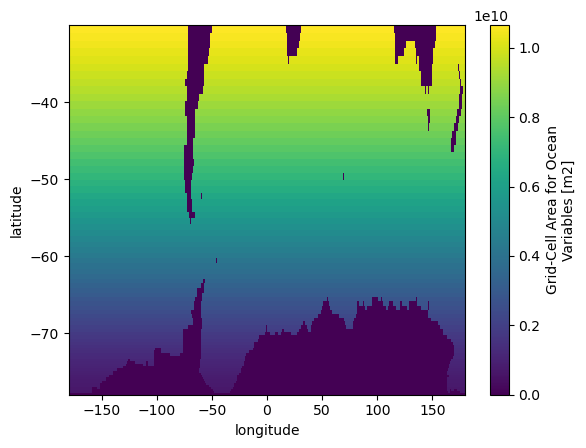

In [14]:
area = xr.open_dataarray(filepath, mask_and_scale = True, drop_variables = ("vertices_latitude", "vertices_longitude"))
#Correcting longitude prior to extracting Southern Ocean
area = uf.corrlong(area)
#Extracting Southern Ocean
area = area.sel(latitude = slice(-90, -30))
#Checking data
area.plot()

## Getting thickness (vertical extent) of grid cells

In [15]:
filename = [f[0] for f in zip(df3['filename'][0])]
filepath = os.path.join(df3['path'][0], filename[0])

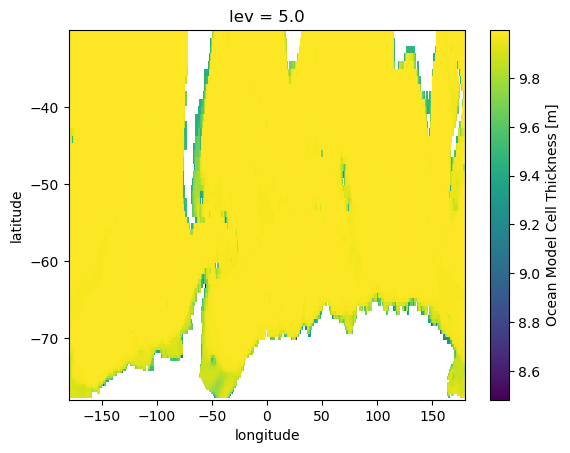

In [16]:
height = xr.open_dataset(filepath, mask_and_scale = True)
#Correcting longitude prior to extracting Southern Ocean
height = uf.corrlong(height)
#Extracting Southern Ocean
height = height.sel(latitude = slice(-90, -30))
#Select only data that is in the upper 200 m - Using lower bound of the depth bins
height = height.thkcello[height.lev_bnds[:,1] <= 200]
#Checking data
height[0].plot()

## Getting volume of grid cells

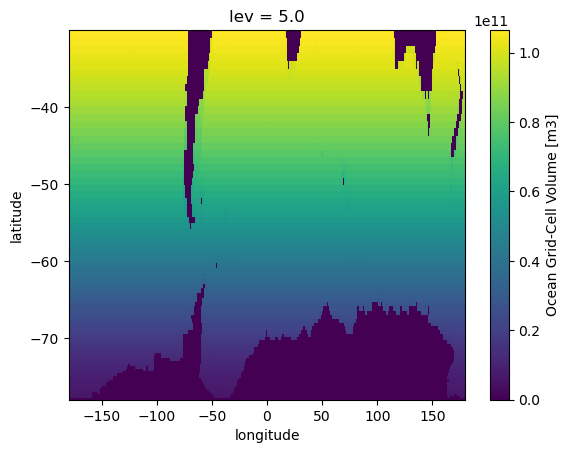

In [13]:
filename = [f[0] for f in zip(df4['filename'][0])]
filepath = os.path.join(df4['path'][0], filename[0])
vol = xr.open_dataset(filepath, mask_and_scale = True)
#Correcting longitude prior to extracting Southern Ocean
vol = uf.corrlong(vol)
# #Extracting Southern Ocean
vol = vol.sel(latitude = slice(-90, -30))
#Select only data that is in the upper 200 m - Using lower bound of the depth bins
vol = vol.volcello[vol.lev_bnds[:,1] <= 200]
#Replace NA values with zeroes prior to weighting
vol = vol.fillna(0)
#Change dataset name prior to weighting
vol.name = 'weights'
#Checking data
vol[0].plot()

# Loading MEASO regions mask
The mask for the MEASO regions was created based on a shapefile sent by A. Constable on 2021-06-24. A detailed workflow of how the mask was created can be found in `0_CreatingMeasoMask.ipynb`.

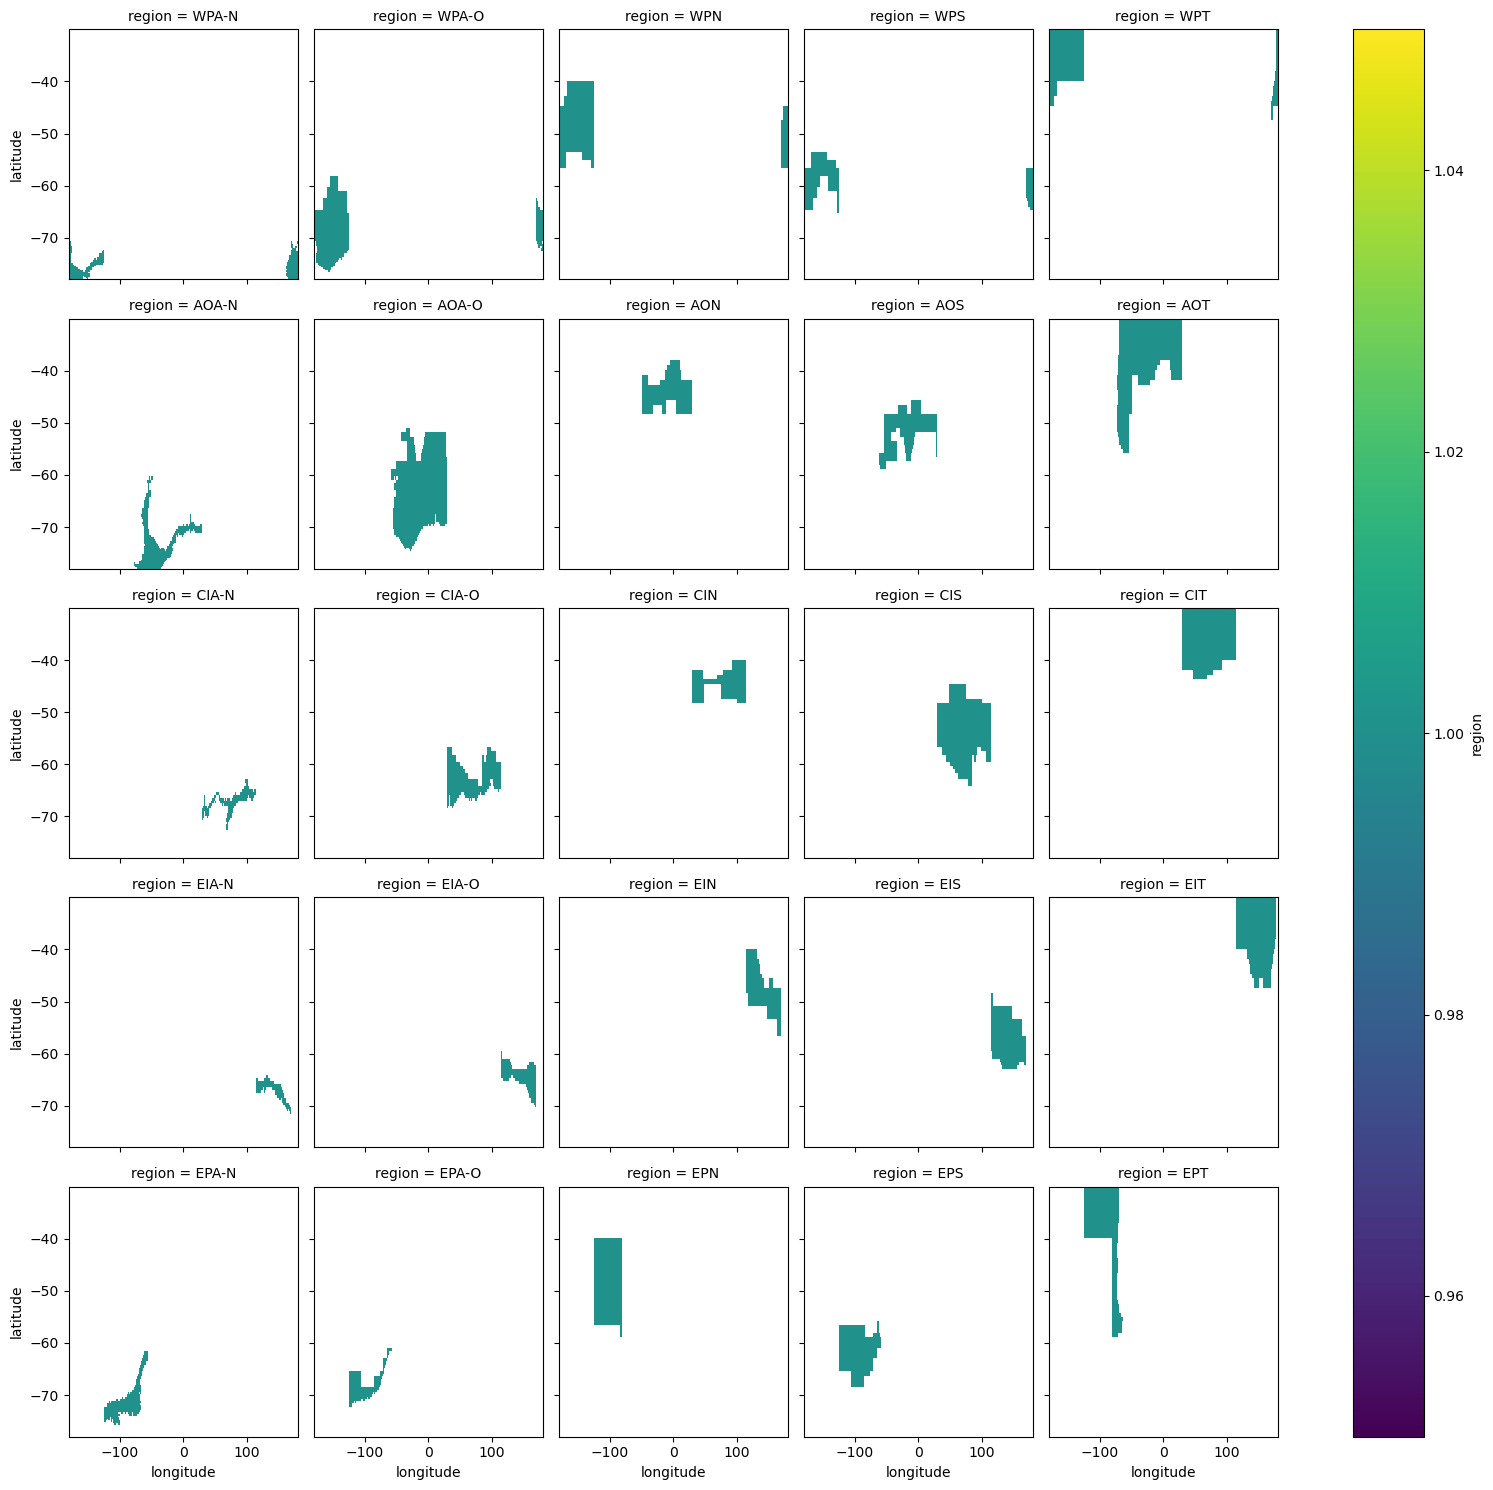

In [11]:
#Loading mask
regions = xr.load_dataarray('MEASO_3Dmask.nc')

#Plotting mask
regions.plot(col = 'region', col_wrap = 5)

# Applying MEASO mask

## Extracting data for each MEASO area

In [14]:
#Getting region names from mask
regionNames = sorted(set(regions.region.values))

#Subsetting shapefiles into regions - Initialise dictionary that will contain sector limits
MEASOregions = {}

#Saving each sector as an entry in the dictionary
for i in regionNames:
    MEASOregions[f"{i}"] = regions.sel(region = i)
    
MEASOregions.keys()

dict_keys(['AOA-N', 'AOA-O', 'AON', 'AOS', 'AOT', 'CIA-N', 'CIA-O', 'CIN', 'CIS', 'CIT', 'EIA-N', 'EIA-O', 'EIN', 'EIS', 'EIT', 'EPA-N', 'EPA-O', 'EPN', 'EPS', 'EPT', 'WPA-N', 'WPA-O', 'WPN', 'WPS', 'WPT'])

## Calculating weighted mean and standard deviations per sector

In [17]:
#Subsetting shapefiles into sectors - Initialise list that will contain summary statistics
weighted_temp_2D = []
weighted_std_temp_2D = []

#Saving each sector as an entry in the dictionary
for i in regionNames:
    #Apply mask to temperature data and cell volume 
    sst_reg = sst_upper200_SO*MEASOregions[i]
    vol_reg = vol*MEASOregions[i]
    #Replace NA values with zeroes
    vol_reg = vol_reg.fillna(0)
    
    #Calculating weighted means
    sst_weighted = sst_reg.weighted(vol_reg)
    #Saving weighted means per sector (lon, lat)
    weighted_temp_2D.append(sst_weighted.mean('lev'))

    #Calculating weighted standard deviation
    step1 = (vol_reg*((sst_reg - sst_weighted.mean('lev'))**2)).sum('lev')
    step2 = ((vol_reg/vol_reg).sum('lev'))-1
    step3 = vol_reg.sum('lev')/((vol_reg/vol_reg).sum('lev'))
    step4 = step1/(step2*step3)
    weighted_std_temp_2D.append(np.sqrt(step4))

## Calculating percentiles per sector

In [40]:
#Subsetting shapefiles into sectors - Initialise list that will contain percentiles
per_temp_2D = []

#Saving each sector as an entry in the dictionary
for i in regionNames:
    #Apply mask to temperature data and cell volume 
    sst_reg = sst_upper200_SO*MEASOregions[i]
    #Calculating percentiles
    per_temp_2D.append(sst_reg.quantile([.2, .5, .8], 'lev'))

## Merging all sector calculations into a single file and saving output
The resulting file will have three dimensions: `time`, `latitude`, and `longitude`. Each time step will contain results for all MEASO sectors. 

In [41]:
#Merging results into a single file
weighted_mean_temp = xr.concat(weighted_temp_2D, dim = 'region').sum('region')
weighted_std_temp = xr.concat(weighted_std_temp_2D, dim = 'region').sum('region')
per_temp = xr.concat(per_temp_2D, dim = 'region').sum('region')

#Changing name of variable before saving file
weighted_mean_temp.name = 'weighted_mean'
weighted_std_temp.name = 'weighted_std'
per_temp.name = 'percentiles'

In [70]:
#Output folder
out = r'/g/data/v45/la6889/MEASO/YearlyMonthly/Temp_Pelagic/'
os.makedirs(out, exist_ok = True)

#Getting years for calculations
yr_start = str(weighted_mean_temp.time.dt.year.values.min())
yr_end = str(weighted_mean_temp.time.dt.year.values.max())

#Saving outputs
weighted_mean_temp.to_netcdf(os.path.join(out, (f'WeightedMeans_Temp_Pelagic_{yr_start}-{yr_end}.nc')))
weighted_std_temp.to_netcdf(os.path.join(out, (f'WeightedStd_Temp_Pelagic_{yr_start}-{yr_end}.nc')))
per_temp.to_netcdf(os.path.join(out, (f'Percentiles_Temp_Pelagic_{yr_start}-{yr_end}.nc')))

# Extracting summaries using 2D MEASO mask

## Loading 2D mask

In [12]:
regions2D = xr.load_dataarray('MEASO_2Dmask.nc')
regions2D

<xarray.DataArray 'region' (latitude: 77, longitude: 360)>
array([[ 1.,  1.,  1., ..., 26., 26., 26.],
       [ 1.,  1.,  1., ..., 26., 26., 26.],
       [ 1.,  1.,  1., ..., 26., 26., 26.],
       ...,
       [ 5.,  5.,  5., ..., 31., 31., 31.],
       [ 5.,  5.,  5., ..., 31., 31., 31.],
       [ 5.,  5.,  5., ..., 31., 31., 31.]])
Coordinates:
  * latitude   (latitude) float64 -77.88 -77.63 -77.38 ... -32.5 -31.5 -30.5
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5

In [78]:
#Loading region keys 
region_key = pd.read_csv('/g/data/v45/la6889/MEASO/MEASO_RegionKeys.csv')
region_key

,Region_ID,Region_name
0,0.0,WPA-O
1,1.0,WPA-N
2,3.0,WPS
3,4.0,WPN
4,5.0,WPT
5,6.0,EPA-N
6,7.0,EPA-O
7,8.0,EPS
8,9.0,EPN
9,10.0,EPT


## Applying mask to regional calculations

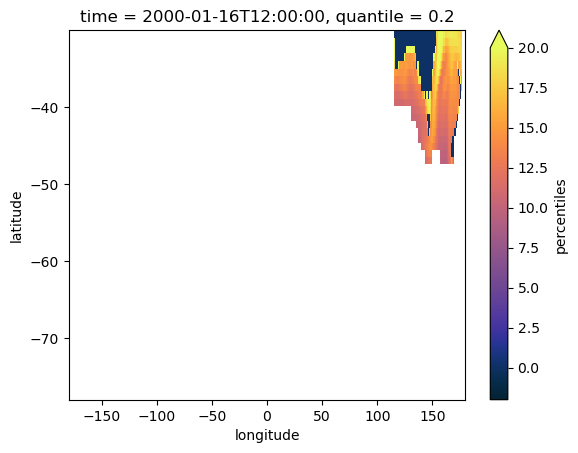

In [84]:
#Let's suppose we want to access the 20th percentile for the EIT region (value of 25 in mask)
#Showing the first time step only
per_temp.where(regions2D == 25).sel(quantile = 0.2)[0].plot(cmap = cm.cm.thermal, 
                                                            vmin = -2, vmax = 20)